In [1]:
import numpy as np 
import pandas as pd 
from transformers import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
from sklearn.externals import joblib
import pickle
import time 



C:\Users\pcmin\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\pcmin\anaconda3\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
# Read in dataset

readin = pd.read_csv(r'C:\Users\pcmin\Desktop\Fall2021\ISE540\Project\SA_data\MA Restaurant.csv')




In [3]:
# Modify dataset into df with reviews content and review stars (2000 for each stars)

def generate_dataset(readin, nrows=11000, min_length=100, max_length = 128):
    df = readin
    df = df.loc[(df['text'].str.len() > min_length) & (df['text'].str.len() <= max_length), ['text', 'review_stars']]
    for rating in range(1, 6, 1):
        df_rating = df[df['review_stars'] == rating]
        if len(df_rating) > nrows//5:
            df_rating = df_rating.iloc[:nrows//5, :]
            df = df.loc[~(df['review_stars'] == rating), :]
            df = df.append(df_rating)
    if len(df) == nrows:
        return df


In [4]:
train_df = generate_dataset(readin)
test_df = generate_dataset(readin)
#train_df.tail()
test_df['review_stars'].value_counts()

1    2200
2    2200
3    2200
4    2200
5    2200
Name: review_stars, dtype: int64

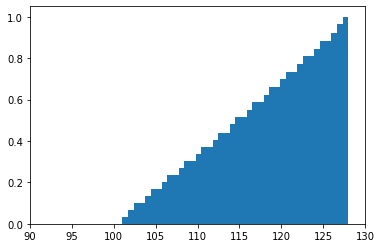

In [5]:
kwargs = {'cumulative': True}
plt.hist(train_df['text'].str.len().tolist() + test_df['text'].str.len().tolist(),cumulative=True, density=True, bins=40)
plt.xlim(left=90, right=130) 
plt.show()

In [6]:
# Count the trainable parameters for the BERT model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
hidden_size = 200
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Total model trainable parameters 108465077
Total head trainable parameters 154805


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
model.classifier

Linear(
  in_features=768, out_features=200, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=200, out_features=5, bias=True)
)

In [9]:
# Tokenizing the text content

tokenized = tokenizer.tokenize('It was good but couldve been better.')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['It', 'was', 'good', 'but', 'could', '##ve', 'been', 'better', '.']
[1135, 1108, 1363, 1133, 1180, 2707, 1151, 1618, 119]
[101, 1135, 1108, 1363, 1133, 1180, 2707, 1151, 1618, 119, 102]


In [64]:
# Converts a list of examples into a list of features that can be directly given as input to a model

def get_features(df, text_col, label_col):

    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].astype(float).values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [11]:
trainset = get_features(train_df, 'text', 'review_stars')
testset = get_features(test_df, 'text', 'review_stars')

  0%|          | 0/11000 [00:00<?, ?it/s]

C:\Users\pcmin\anaconda3\lib\site-packages\transformers\data\processors\glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
<ipython-input-10-0731818dd7c8>:15: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)


  0%|          | 0/11000 [00:00<?, ?it/s]

In [12]:
X_valid, X_train = train_test_split(np.arange(len(trainset)), random_state=4, train_size=0.1)
total_size = len(trainset)
val_dataset = TensorDataset(*trainset[X_valid])
train_dataset = TensorDataset(*trainset[X_train])
assert total_size == len(val_dataset) + len(train_dataset)

In [13]:
# Run the model

model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

batch_size = 16
gradient = 32
assert batch_size <= gradient and gradient % batch_size == 0

accumulation_steps = gradient//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=batch_size*2, shuffle=False)

#epochs = 25
epochs = 5

# Apply AdamW as the optimizer

lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

In [14]:
tr_losses = []
v_losses = []

for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}
       
        loss = model(**feed_dict).loss
    
        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()} 

            loss, pred = model(**feed_dict).loss, model(**feed_dict).logits
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')
#    torch.save(model.classifier.state_dict(), f'/kaggle/working/yelp-head{epoch}.pt')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/619 [00:00<?, ?it/s]

train NLL loss: 1.5466338611766095


val batch:   0%|          | 0/35 [00:00<?, ?it/s]

validation BCE loss: 1.4215533699308123
epoch 2


batch:   0%|          | 0/619 [00:00<?, ?it/s]

train NLL loss: 1.406718305124027


val batch:   0%|          | 0/35 [00:00<?, ?it/s]

validation BCE loss: 1.3327447959354946
epoch 3


batch:   0%|          | 0/619 [00:00<?, ?it/s]

train NLL loss: 1.3421815064689069


val batch:   0%|          | 0/35 [00:00<?, ?it/s]

validation BCE loss: 1.2853772333690099
epoch 4


batch:   0%|          | 0/619 [00:00<?, ?it/s]

train NLL loss: 1.333888559137292


val batch:   0%|          | 0/35 [00:00<?, ?it/s]

validation BCE loss: 1.3579153980527605
epoch 5


batch:   0%|          | 0/619 [00:00<?, ?it/s]

train NLL loss: 1.3003985694036344


val batch:   0%|          | 0/35 [00:00<?, ?it/s]

validation BCE loss: 1.249195921421051


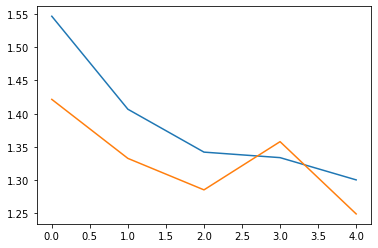

In [15]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [16]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/344 [00:00<?, ?it/s]

In [112]:
# Evaluation

model_predictions = np.array([i for k in batch_predictions for i in k ])

model_predictions = np.argmax(model_predictions, axis=1)
model_actual = np.array([i for k in batch_actual for i in k ])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

print("The accuracy score of our Model is: %.3f " % accuracy_score(model_actual, model_predictions))
print("The precision score of our Model is: %.3f " % precision_score(model_actual, model_predictions, average='micro'))
print("The recall score of our Model is: %.3f " % recall_score(model_actual, model_predictions, average='micro'))
print("The F1 score of our Model is: %.3f " % f1_score(model_actual, model_predictions, average='micro'))


The accuracy score of our Model is: 0.431 
The precision score of our Model is: 0.431 
The recall score of our Model is: 0.431 
The F1 score of our Model is: 0.431 


In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='BERT Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

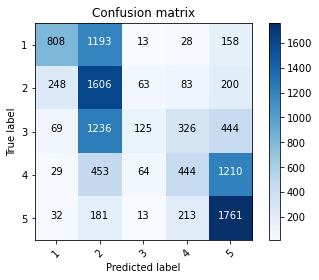

In [23]:
# Compute the confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(model_actual, model_predictions) 

# Plot the confusion matrix

plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()

In [24]:
# Test

sample_data = readin.sample(10000)
sample_set = get_features(sample_data, 'text', 'review_stars')
sample_dataloader = DataLoader(sample_set, batch_size=batch_size*2, shuffle=False)
test_batch_predictions, test_batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(sample_dataloader, total=len(sample_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        test_batch_predictions.append(pred.numpy())
        test_batch_actual.append(labels)



  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-10-0731818dd7c8>:15: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)


val batch:   0%|          | 0/313 [00:00<?, ?it/s]

In [25]:
# Test Evaluation

test_predictions = np.array([i for k in test_batch_predictions for i in k ])

test_predictions = np.argmax(test_predictions, axis=1)
test_actual = np.array([i for k in test_batch_actual for i in k ])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

print("The accuracy score of our Model is: %.3f " % accuracy_score(test_actual, test_predictions))
print("The precision score of our Model is: %.3f " % precision_score(test_actual, test_predictions, average='micro'))
print("The recall score of our Model is: %.3f " % recall_score(test_actual, test_predictions, average='micro'))
print("The F1 score of our Model is: %.3f " % f1_score(test_actual, test_predictions, average='micro'))

The accuracy score of our Model is: 0.448 
The precision score of our Model is: 0.448 
The recall score of our Model is: 0.448 
The F1 score of our Model is: 0.448 


In [34]:
# Save model
#PATH = 'C:/Users/pcmin/Desktop/Fall2021/ISE540/Project/Model/best_bert_model.pt'

# Save
#torch.save(model.state_dict(), PATH)



In [133]:
# new test
new = pd.read_csv(r'C:\Users\pcmin\Desktop\sentiment_test.csv')
mapping = {'neg': 1,'neu': 3, 'pos': 5}
new.sentiment_truth = [mapping[item] for item in new.sentiment_truth]
new

new_data = new
new_set = get_features(new_data, 'new_review', 'sentiment_truth')
new_dataloader = DataLoader(new_set, batch_size=batch_size*2, shuffle=False)
new_batch_predictions, new_batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(new_dataloader, total=len(new_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        score = pred.numpy()
        new_batch_predictions.append(score)
        new_batch_actual.append(labels)

  0%|          | 0/426 [00:00<?, ?it/s]

<ipython-input-64-8450d43ed8db>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)


val batch:   0%|          | 0/14 [00:00<?, ?it/s]

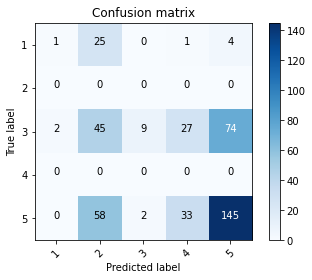

In [116]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(new_actual, new_predictions) 

# Plot the confusion matrix

plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()

In [148]:
new_predictions = np.array([i for k in new_batch_predictions for i in k ])
new_predictions = np.argmax(new_predictions, axis=1)

a = pd.read_csv(r'C:\Users\pcmin\Desktop\sentiment_test.csv')

new_actual = a['sentiment_truth'].tolist()

new_predictions = ['pos' if element == 4 or element == 5 else element for element in new_predictions]
new_predictions = ['neu' if element == 3 or element == 2 else element for element in new_predictions]
new_predictions = ['neg' if element == 0 or element == 1 else element for element in new_predictions]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

print("The accuracy score of our Model is: %.3f " % accuracy_score(new_actual, new_predictions))
print("The precision score of our Model is: %.3f " % precision_score(new_actual, new_predictions, average='weighted'))
print("The recall score of our Model is: %.3f " % recall_score(new_actual, new_predictions, average='weighted'))
print("The F1 score of our Model is: %.3f " % f1_score(new_actual, new_predictions, average='weighted'))

The accuracy score of our Model is: 0.486 
The precision score of our Model is: 0.562 
The recall score of our Model is: 0.486 
The F1 score of our Model is: 0.491 


In [138]:
print(len(new_predictions))

426


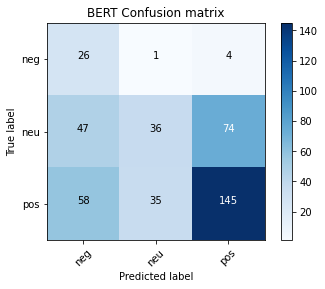

In [150]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(new_actual, new_predictions) 

# Plot the confusion matrix

plot_confusion_matrix(confusion_mtx, classes = ['neg','neu','pos'])
plt.show()